# Linear Regression 기반의 검색 빈도수를 이용한 주가예측

# 0. Install packages

In [1]:
!pip install finance-datareader
!pip install -U finance-datareader # 업데이트

In [2]:
import torch
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import urllib.request
import json
import re

# 1. Prepare datasests

## 1-1. 주가 데이터 불러오기

In [3]:
# Random seed to make results deterministic and reproducible
torch.manual_seed(0)

# 한국거래소에 상장된 모든 종목 리스트 가져오기
import FinanceDataReader as fdr
df_krx = fdr.StockListing('KRX')
df_krx.head()

,Symbol,Market,Name,Sector,Industry,ListingDate,SettleMonth,Representative,HomePage,Region
0,060310,KOSDAQ,3S,전자부품 제조업,반도체 웨이퍼 캐리어,2002-04-23,03월,김세완,http://www.3sref.com,서울특별시
1,095570,KOSPI,AJ네트웍스,산업용 기계 및 장비 임대업,"렌탈(파렛트, OA장비, 건설장비)",2015-08-21,12월,"박대현, 손삼달",http://www.ajnet.co.kr,서울특별시
2,006840,KOSPI,AK홀딩스,기타 금융업,지주사업,1999-08-11,12월,"채형석, 이석주(각자 대표이사)",http://www.aekyunggroup.co.kr,서울특별시
3,054620,KOSDAQ,APS홀딩스,기타 금융업,인터넷 트래픽 솔루션,2001-12-04,12월,정기로,http://www.apsholdings.co.kr,경기도
4,265520,KOSDAQ,AP시스템,특수 목적용 기계 제조업,디스플레이 제조 장비,2017-04-07,12월,김영주,http://www.apsystems.co.kr,경기도


In [4]:
df = fdr.DataReader('047810','2020-01-01', '2022-05-10') # NCsoft 주가를 2020년부터 현시점까지 가져온다

In [5]:
df

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2020-01-02,34100,34150,33800,33800,228661,-0.007342
2020-01-03,33850,34100,33750,33950,294440,0.004438
2020-01-06,33850,34700,33800,33900,502565,-0.001473
2020-01-07,34100,34100,33450,33700,312663,-0.005900
2020-01-08,33600,33650,32450,32450,686442,-0.037092
...,...,...,...,...,...,...
2022-05-03,47100,47750,46150,47200,1619153,0.016146
2022-05-04,47300,48700,46650,48150,1750174,0.020127
2022-05-06,47800,48950,47300,48500,1091440,0.007269


In [6]:
df = df.fillna(0)

(array([737425., 737516., 737607., 737699., 737791., 737881., 737972.,
        738064., 738156., 738246.]),
 <a list of 10 Text major ticklabel objects>)

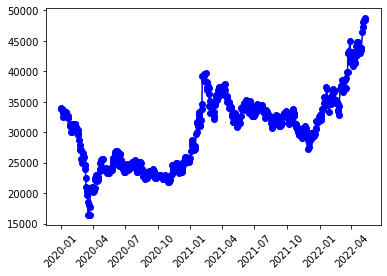

In [7]:
plt.plot(df['Close'], 'bo-')
plt.xticks(rotation=45)

## 1-2. Naver API 키워드 검색 데이터 불러오기

In [8]:
import os
import sys
import urllib.request
client_id = "8sAydq_QSOxKcICuD2Og"
client_secret = "OruQjbmaXF"
url = "https://openapi.naver.com/v1/datalab/search";
body = "{\"startDate\":\"2020-01-01\",\"endDate\":\"2022-05-10\",\"timeUnit\":\"date\",\"keywordGroups\":[{\"groupName\":\"KAI_0\",\"keywords\":[\"누리호\"]}, {\"groupName\":\"KAI_1\",\"keywords\":[\"실적\"]}, {\"groupName\":\"KAI_2\",\"keywords\":[\"실패\"]}]}";

request = urllib.request.Request(url)
request.add_header("X-Naver-Client-Id",client_id)
request.add_header("X-Naver-Client-Secret",client_secret)
request.add_header("Content-Type","application/json")
response = urllib.request.urlopen(request, data=body.encode("utf-8"))
rescode = response.getcode()
if(rescode==200):
    response_body = response.read()
    #print(response_body.decode('utf-8'))
    search_count = response_body.decode('utf-8')
else:
    print("Error Code:" + rescode)

In [9]:
search_count_json = json.loads(search_count)

In [10]:
#search_count_json

## 1-3. 데이터 전처리 및 Merge하기

In [11]:
for idx in range(len(search_count_json["results"])):
  
  df_json = pd.DataFrame(search_count_json["results"][idx]["data"])
  column_name = 'Key_Count'+str(idx)
  df_json.columns = ['Date', column_name]
  df_json['Date'] = pd.to_datetime(df_json['Date'])
  df_json.reset_index(drop=True)
  df_json.set_index("Date")
  #Please refer to the section of "Merging asof" in https://pandas.pydata.org/docs/user_guide/merging.html
  df = pd.merge_asof(df, df_json, on="Date", by="Date")

In [12]:
df_all = df

In [13]:
df_all

,Date,Open,High,Low,Close,Volume,Change,Key_Count0,Key_Count1,Key_Count2
0,2020-01-02,34100,34150,33800,33800,228661,-0.007342,0.00603,0.01166,0.01334
1,2020-01-03,33850,34100,33750,33950,294440,0.004438,0.00696,0.01212,0.01415
2,2020-01-06,33850,34700,33800,33900,502565,-0.001473,0.00725,0.01247,0.01549
3,2020-01-07,34100,34100,33450,33700,312663,-0.005900,0.00794,0.01531,0.01601
4,2020-01-08,33600,33650,32450,32450,686442,-0.037092,0.00748,0.01613,0.01810
...,...,...,...,...,...,...,...,...,...,...
577,2022-05-03,47100,47750,46150,47200,1619153,0.016146,0.04874,0.01381,0.01926
578,2022-05-04,47300,48700,46650,48150,1750174,0.020127,0.04903,0.01195,0.01735
579,2022-05-06,47800,48950,47300,48500,1091440,0.007269,0.04270,0.00899,0.01758
580,2022-05-09,48600,49950,48300,48800,1578796,0.006186,0.04793,0.01375,0.01967


In [14]:
df_all["Change"].sum() # 전체 주가의 변동폭은 2020년부터 현재까지 증가일까 감소일까? 최종 주가는 빠졌는데 놀랍게도 증가함.. 이는 복리의 함정

0.5401458879663686

In [15]:
df_all[df_all["Date"] > '2022-01-01']["Change"].sum() #조금 더 범위를 좁혀 그러면 2022년 전체 주가 변동폭만 검색해보자, 역시 폭락중 불쌍한 임교수

0.4325107515158091

In [16]:
df_all[df_all["Key_Count0"].notnull()]["Change"].sum() # 그렇다면 해당 키워드가 검색된 날만 뽑아 주가가 상승했는지 하락인지 살펴보자.

0.5401458879663686

In [17]:
# Fill nan as 0
df_all = df_all.fillna(0)
df_all.any().isnull()

Date          False
Open          False
High          False
Low           False
Close         False
Volume        False
Change        False
Key_Count0    False
Key_Count1    False
Key_Count2    False
dtype: bool

In [18]:
df_all

,Date,Open,High,Low,Close,Volume,Change,Key_Count0,Key_Count1,Key_Count2
0,2020-01-02,34100,34150,33800,33800,228661,-0.007342,0.00603,0.01166,0.01334
1,2020-01-03,33850,34100,33750,33950,294440,0.004438,0.00696,0.01212,0.01415
2,2020-01-06,33850,34700,33800,33900,502565,-0.001473,0.00725,0.01247,0.01549
3,2020-01-07,34100,34100,33450,33700,312663,-0.005900,0.00794,0.01531,0.01601
4,2020-01-08,33600,33650,32450,32450,686442,-0.037092,0.00748,0.01613,0.01810
...,...,...,...,...,...,...,...,...,...,...
577,2022-05-03,47100,47750,46150,47200,1619153,0.016146,0.04874,0.01381,0.01926
578,2022-05-04,47300,48700,46650,48150,1750174,0.020127,0.04903,0.01195,0.01735
579,2022-05-06,47800,48950,47300,48500,1091440,0.007269,0.04270,0.00899,0.01758
580,2022-05-09,48600,49950,48300,48800,1578796,0.006186,0.04793,0.01375,0.01967


## 1-4. Feature Selection

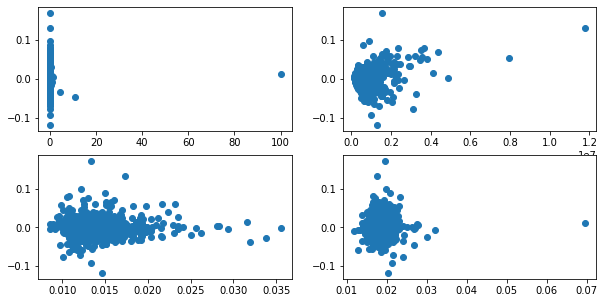

In [19]:
## You need to visualized a relational graph
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

ax1.scatter(df_all["Key_Count0"], df_all["Change"])
ax2.scatter(df_all["Volume"], df_all["Change"])
ax3.scatter(df_all["Key_Count1"], df_all["Change"])
ax4.scatter(df_all["Key_Count2"], df_all["Change"])


# 2. Define Model

In [20]:
class LinearModel(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LinearModel, self).__init__()
        self.linear_classifier = torch.nn.Linear(input_dim, output_dim, bias=True)

    def forward(self, x):
        x = self.linear_classifier(x.unsqueeze(0))
        return x

# 3. Define the loss function and the optimizer

In [21]:
input_dim = 3
output_dim = 1
learning_rate = 0.001
model = LinearModel(input_dim, output_dim)

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
loss_function = torch.nn.MSELoss()

# 4. Define train function

In [22]:
def train(train_x, train_y, loss_function, optimizer, model):
  total_loss = []

  for idx in range(len(train_x)):
    model.train()
    optimizer.zero_grad()
    train_x_tensor = torch.tensor(train_x[idx]).float() #convert numpy to torch tensor
    train_y_tensor = torch.tensor(train_y[idx]).float()
    print(train_x_tensor)
    logit = model(train_x_tensor)
    loss = loss_function(logit, train_y_tensor)
    total_loss.append(loss.item())

    loss.backward()
    optimizer.step()

  return total_loss

# 5. Training 

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df[['Scaled_Key_Count0', 'Scaled_Key_Count1', 'Scaled_Key_Count2']] = scaler.fit_transform(df[['Key_Count0', 'Key_Count1', 'Key_Count2']])

In [24]:
df_all = df

In [25]:
df_all = df_all.fillna(0)
df_all.any().isnull()

Date                 False
Open                 False
High                 False
Low                  False
Close                False
Volume               False
Change               False
Key_Count0           False
Key_Count1           False
Key_Count2           False
Scaled_Key_Count0    False
Scaled_Key_Count1    False
Scaled_Key_Count2    False
dtype: bool

In [26]:
x_scaled = df_all[['Scaled_Key_Count0', 'Scaled_Key_Count1', 'Scaled_Key_Count2']].to_numpy()
y_scaled = df_all["Change"].to_numpy()

train_x, test_x, train_y, test_y = train_test_split(x_scaled, y_scaled, test_size=0.2)

In [27]:
best_model = None
num_epoch = 100
loss_epoch = []

for epoch in range(num_epoch):
  loss_list = train(train_x, train_y, loss_function, optimizer, model)
  loss_epoch.append(sum(loss_list)/len(train_x))

tensor([1.3401e-05, 2.9113e-01, 1.7824e-01])
tensor([1.0970e-04, 3.9881e-01, 6.7511e-02])
tensor([2.8401e-05, 1.3814e-01, 1.3589e-01])
tensor([1.7761e-04, 1.7898e-01, 1.4804e-01])
tensor([2.1501e-05, 2.4359e-01, 1.1073e-01])
tensor([0.0075, 0.2481, 0.0866])
tensor([0.0017, 0.1099, 0.0654])
tensor([3.5401e-05, 2.6513e-01, 1.0569e-01])
tensor([6.6203e-05, 1.9829e-01, 1.0066e-01])
tensor([2.3801e-05, 1.9606e-01, 4.1305e-02])
tensor([0.0003, 0.1058, 0.1682])
tensor([2.1061e-04, 2.8221e-01, 1.1281e-01])
tensor([3.6602e-05, 1.0769e-01, 1.1073e-01])
tensor([5.3402e-05, 4.1812e-01, 1.3086e-01])
tensor([0.0001, 0.1337, 0.0675])
tensor([0.0003, 0.1144, 0.0837])
tensor([1.9701e-05, 2.1129e-01, 6.1437e-02])
tensor([0.0016, 0.2176, 0.3162])
tensor([0.0004, 0.0754, 0.1149])
tensor([4.1802e-05, 2.1129e-01, 1.1489e-01])
tensor([1.1610e-04, 8.5555e-01, 1.0274e-01])
tensor([2.7301e-05, 1.3145e-01, 3.9222e-02])
tensor([1.7401e-05, 1.3814e-01, 1.5706e-01])
tensor([4.7602e-05, 2.1983e-01, 1.2287e-01])
tens

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
tensor([6.3803e-05, 4.0104e-01, 2.5182e-01])
tensor([0.0002, 0.0520, 0.1279])
tensor([5.9803e-05, 2.5214e-01, 1.4405e-01])
tensor([0.0004, 0.1552, 0.1027])
tensor([0.0005, 0.2911, 0.0856])
tensor([2.3201e-05, 3.2566e-01, 1.3190e-01])
tensor([0.0004, 0.1251, 0.1258])
tensor([3.0201e-05, 1.5522e-01, 8.2610e-02])
tensor([4.8802e-05, 1.5522e-01, 1.2287e-01])
tensor([3.4201e-05, 2.0052e-01, 1.0882e-01])
tensor([0.0003, 0.1530, 0.1229])
tensor([3.6002e-05, 1.8975e-01, 1.7824e-01])
tensor([4.3502e-05, 2.5436e-01, 1.2287e-01])
tensor([1.3901e-05, 1.3145e-01, 1.1281e-01])
tensor([0.0003, 0.1359, 0.1078])
tensor([9.7504e-05, 3.1043e-01, 1.2791e-01])
tensor([0.0002, 0.1400, 0.1027])
tensor([1.1841e-04, 3.1675e-01, 2.7386e-01])
tensor([1.4861e-04, 1.8344e-01, 7.4453e-02])
tensor([9.6304e-05, 3.9658e-01, 1.5515e-01])
tensor([5.2802e-05, 2.0498e-01, 1.3797e-01])
tensor([2.1501e-05, 4.9127e-01, 1.0882e-01])
tensor([2.8401e-05, 1.8975e-01, 1.2999e-01])
tensor([3.600

In [36]:
linear_weight[0][0]

0.05760259

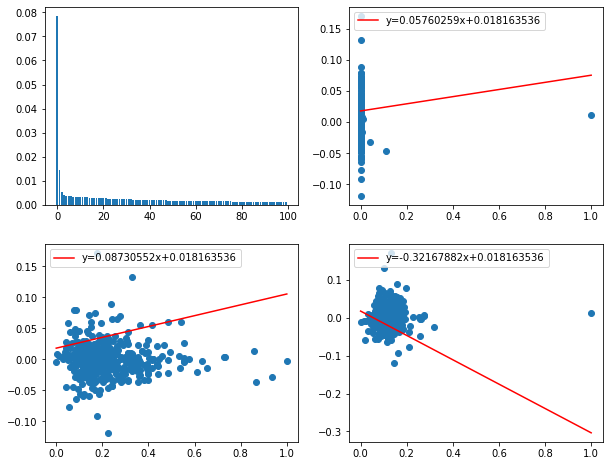

In [37]:
## You need to visualized a relational graph
fig = plt.figure(figsize=(10,8))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

ax1.bar(range(100), loss_epoch)
ax2.scatter(train_x.transpose()[0], train_y)
x = np.linspace(0,1,100)
linear_weight = model.linear_classifier.weight.detach().numpy()
lienar_bias = model.linear_classifier.bias.detach().numpy()
y = linear_weight.transpose()[0]*x+lienar_bias
y = y.reshape((100))
ax2.plot(x, y, '-r', label='y='+str(linear_weight[0][0])+'x+'+str(lienar_bias[-1]))
ax2.legend(loc='upper left')

ax3.scatter(train_x.transpose()[1], train_y)
x = np.linspace(0,1,100)
linear_weight = model.linear_classifier.weight.detach().numpy()
lienar_bias = model.linear_classifier.bias.detach().numpy()
y = linear_weight.transpose()[1]*x+lienar_bias
y = y.reshape((100))
ax3.plot(x, y, '-r', label='y='+str(linear_weight[0][1])+'x+'+str(lienar_bias[-1]))
ax3.legend(loc='upper left')

ax4.scatter(train_x.transpose()[2], train_y)
x = np.linspace(0,1,100)
linear_weight = model.linear_classifier.weight.detach().numpy()
lienar_bias = model.linear_classifier.bias.detach().numpy()
y = linear_weight.transpose()[2]*x+lienar_bias
y = y.reshape((100))
ax4.plot(x, y, '-r', label='y='+str(linear_weight[0][2])+'x+'+str(lienar_bias[-1]))
ax4.legend(loc='upper left')

# 6. Prediction

In [29]:
def predict(key_count, model):
  model.eval()
  logit = model(key_count)
  return logit

In [30]:
key_count = np.array([[20, 30, 30]])
scaled_input = scaler.transform(key_count.reshape(1,-1))

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"


In [31]:
df_all.max()
predicted = predict(torch.FloatTensor(scaled_input), model)

In [32]:
print("검색량이"+str(key_count)+"일때 주가는", str(predicted.item()*100) )

검색량이[[20 30 30]]일때 주가는 -7015.63720703125


In [33]:
# scaling function for input data
def minmax_scaler(data):
    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)
    return numerator / (denominator + 1e-7)

# scaling function for input data
def minmax_scaler(data):
    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)
    return numerator / (denominator + 1e-7)


# make dataset to train